In [8]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import time  # 計時用, 目前沒用到
import gc  # 記憶體的垃圾回收, 用法: gc.collect()
import os  # 建立資料夾
import matplotlib.pyplot as plt  # 畫圖用
import json  # 儲存 Session 的統計資料用
plt.rcParams['font.family']=['Noto Sans TC'] # 中文顯示

/Users/bula/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/bula/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [7]:
DATA_DIR = 'data'

### 1. 分群之前

In [3]:
# load member features
member_df = pd.read_csv(f'MemberA_behavior_data/member_features_2.csv')
print("member_df", member_df.shape)
display(member_df.head(1))

member_df (26598, 13)


,MemberID,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
0,GhKK5xXtrl1ZjIyXUY7Qr5hRqMwkbLvwMFqEObZ2oeI=,363.8154,1397.999,21.769231,9.0,3.769231,1.285714,3012.718,2983.357,34.487,0.181818,1.0,846.43632


In [4]:
# 哪個 columns 有 nan
print("member_df columns with NaN:")
print(member_df.columns[member_df.isna().any()].tolist())

# 有多少含有 NaN 的 row
print("member_df rows with NaN:", member_df.isna().any(axis=1).sum())

member_df columns with NaN:
['view_to_buy_duration_median', 'add_to_buy_duration_median', 'view_to_add_duration_median', 'purchase_randomess']
member_df rows with NaN: 2149


In [5]:
# 哪個 columns 有 inf
numeric_df = member_df.select_dtypes(include=[np.number])
print("member_df columns with inf:")
print(numeric_df.columns[np.isinf(numeric_df).any()].tolist())

# 有多少含有 inf 的 row
print("member_df rows with inf:", np.isinf(numeric_df).any(axis=1).sum())

member_df columns with inf:
[]
member_df rows with inf: 0


In [6]:
member_df

,MemberID,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
0,GhKK5xXtrl1ZjIyXUY7Qr5hRqMwkbLvwMFqEObZ2oeI=,363.815400,1.397999e+03,21.769231,9.0,3.769231,1.285714,3012.7180,2983.3570,34.4870,0.181818,1.000000,846.436320
1,BEE1QykNZUQ6VNPmnkoPv7Ry34rSi24eQAtlDacWUJc=,337607.951000,3.376080e+05,5.952381,4.0,0.523810,1.000000,477.8220,322.6850,155.1370,0.250000,2.000000,NaN
2,XJXKHR+cTo9cwinRalfkVOvshVhvNtw+SzZ5WPme5+0=,61.668167,3.700090e+02,12.166667,10.5,2.833333,0.400000,672.0330,669.3110,2.7220,0.166667,1.125000,0.000000
3,WRy4jrS8JIRXqYXZdybGv/w702dnGrxYQzcEgmfCzN8=,12.232105,8.075800e+01,11.761905,8.0,2.714286,1.428571,827.7020,775.6990,7.5420,0.066667,1.000000,0.000000
4,CHL7cDPUa1iy/mwfOokQOFQ/iCExGp/RpWr4xh/ZB5M=,99.733385,1.209517e+03,41.000000,41.0,21.000000,0.750000,1480.0025,1472.0495,6.7085,2.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26593,yNBuS+pj8BeUnvD0a3641B/WuQiQ7CfDc08r3ZPZQ/A=,329397.730604,1.021081e+07,21.423729,10.0,4.328814,0.706806,59045.6580,41109.8115,39.3370,0.210526,1.432049,814.492473
26594,9hMBEuoZHPm0KheEgqtLkvextSbsG18yVG/kU0BNRqc=,4.174727,4.592200e+01,8.235294,4.0,1.411765,0.125000,NaN,NaN,NaN,0.125000,1.000000,NaN
26595,YdCXdhtOGdHFm3k6ddxfJEKAMEqicfs9ItIEg+t02Do=,10.783957,1.599910e+02,9.809524,6.0,3.142857,1.153846,472.5845,437.7870,22.4935,4.000000,1.000000,455.088636
26596,ArNx5xzqOKsi03eEIMoFY4OgncNy4OBFz+blij7hLK0=,865152.719600,8.650766e+06,12.769231,6.0,2.384615,2.000000,1386.7875,327.6050,68.5250,0.428571,1.153846,517.952287


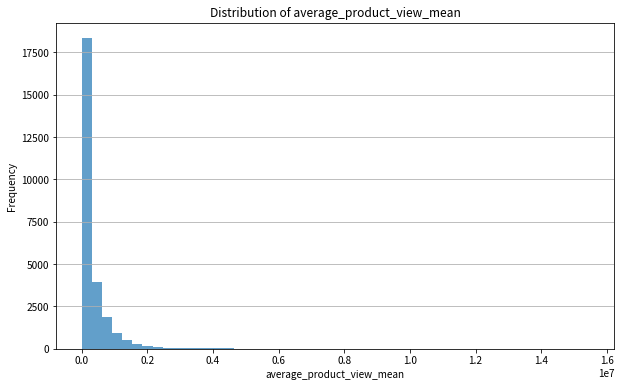

In [8]:
# plt columns 分佈
col_name = 'average_product_view_mean'
plt.figure(figsize=(10, 6))
plt.hist(member_df[f'{col_name}'], bins=50, alpha=0.7)
plt.title(f'Distribution of {col_name}')
plt.xlabel(f'{col_name}')
plt.ylabel('Frequency')
plt.grid(axis='y')

### 2. K-means 分群

In [9]:
# 每個 columns 的統計資料
print("member_df columns statistics:")
display(member_df.describe())

member_df columns statistics:


,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
count,2.659800e+04,2.659800e+04,26598.000000,26598.000000,26598.000000,26598.000000,2.576900e+04,2.590100e+04,2.524600e+04,26598.000000,26598.000000,25440.000000
mean,3.333049e+05,3.715593e+06,15.425332,8.068257,4.225234,0.751805,3.281206e+05,2.455960e+05,3.397244e+04,0.416149,1.353943,168.349051
std,7.085026e+05,4.543698e+06,10.285374,8.702559,4.537130,0.582386,1.212287e+06,9.909413e+05,6.906175e+05,0.601727,0.391810,285.522227
min,0.000000e+00,0.000000e+00,1.333333,1.000000,0.007828,0.000000,-1.195909e+07,-1.295489e+07,-1.531150e+07,0.000000,1.000000,0.000000
25%,5.151919e+02,3.278406e+03,9.619683,4.500000,1.758955,0.384615,7.871750e+02,6.740365e+02,6.380750e+00,0.133333,1.120000,0.000000
50%,8.759606e+04,1.148739e+06,13.049291,6.000000,3.000000,0.650000,3.122764e+03,2.258822e+03,1.656650e+01,0.250000,1.272727,72.416811
75%,4.110102e+05,7.101603e+06,18.083333,9.000000,5.100000,1.000000,8.346191e+04,5.332348e+04,5.009900e+01,0.500000,1.478261,240.299774
max,1.545095e+07,1.565112e+07,210.000000,210.000000,114.000000,16.571429,1.541916e+07,1.443080e+07,1.522667e+07,34.000000,13.000000,21513.750815


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# 儲存 member_id 以後面合併
member_ids = member_df['MemberID']
X = member_df.drop(columns=['MemberID'])  # 去掉 MemberID, 只留下特徵 X

# cat features: 自動只對 cat feature 做 1-hot
#X = pd.get_dummies(X, drop_first=True)  # 丟掉第一個類別 ∵ vec=0

# 對 inf 取代為 0, 因為是某個 / 0 的結果
X_noinf = X.replace([np.inf, -np.inf], np.nan)  # 先把 inf 轉成 NaN

# 平均值填補 NaN
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X_noinf)

# num features: 標準化數值
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
display(X_scaled_df)

,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
0,-0.469931,-0.817454,0.616800,0.107067,-0.100507,0.916780,-0.272462,-0.248108,-0.050441,-0.389438,-0.903371,2.428400e+00
1,0.006074,-0.743458,-0.921029,-0.467487,-0.815823,0.426177,-0.274587,-0.250829,-0.050262,-0.276125,1.648933,1.017852e-16
2,-0.470357,-0.817680,-0.316831,0.279434,-0.306786,-0.604087,-0.274424,-0.250474,-0.050488,-0.414618,-0.584333,-6.028999e-01
3,-0.470427,-0.817744,-0.356185,-0.007843,-0.333025,1.162081,-0.274293,-0.250365,-0.050481,-0.580810,-0.903371,-6.028999e-01
4,-0.470304,-0.817496,2.486555,3.784216,3.697289,-0.003100,-0.273747,-0.249653,-0.050482,2.632222,-0.903371,-6.028999e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
26593,-0.005515,1.429527,0.583208,0.221978,0.022830,-0.077268,-0.225503,-0.209118,-0.050434,-0.341727,0.199348,2.314001e+00
26594,-0.470439,-0.817752,-0.699068,-0.467487,-0.620111,-1.076292,0.000000,0.000000,0.000000,-0.483865,-0.903371,1.017852e-16
26595,-0.470429,-0.817727,-0.546010,-0.237665,-0.238564,0.690348,-0.274591,-0.250711,-0.050459,5.956049,-0.903371,1.026886e+00
26596,0.750679,1.086178,-0.258245,-0.237665,-0.405687,2.143285,-0.273825,-0.250824,-0.050391,0.020645,-0.510709,1.252016e+00


In [12]:
# KMeans 分群 (分 4 群)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled_df)

# 加入分群結果
member_df['cluster'] = clusters
display(member_df)

,MemberID,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess,cluster
0,GhKK5xXtrl1ZjIyXUY7Qr5hRqMwkbLvwMFqEObZ2oeI=,363.815400,1.397999e+03,21.769231,9.0,3.769231,1.285714,3012.7180,2983.3570,34.4870,0.181818,1.000000,846.436320,1
1,BEE1QykNZUQ6VNPmnkoPv7Ry34rSi24eQAtlDacWUJc=,337607.951000,3.376080e+05,5.952381,4.0,0.523810,1.000000,477.8220,322.6850,155.1370,0.250000,2.000000,NaN,1
2,XJXKHR+cTo9cwinRalfkVOvshVhvNtw+SzZ5WPme5+0=,61.668167,3.700090e+02,12.166667,10.5,2.833333,0.400000,672.0330,669.3110,2.7220,0.166667,1.125000,0.000000,1
3,WRy4jrS8JIRXqYXZdybGv/w702dnGrxYQzcEgmfCzN8=,12.232105,8.075800e+01,11.761905,8.0,2.714286,1.428571,827.7020,775.6990,7.5420,0.066667,1.000000,0.000000,1
4,CHL7cDPUa1iy/mwfOokQOFQ/iCExGp/RpWr4xh/ZB5M=,99.733385,1.209517e+03,41.000000,41.0,21.000000,0.750000,1480.0025,1472.0495,6.7085,2.000000,1.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26593,yNBuS+pj8BeUnvD0a3641B/WuQiQ7CfDc08r3ZPZQ/A=,329397.730604,1.021081e+07,21.423729,10.0,4.328814,0.706806,59045.6580,41109.8115,39.3370,0.210526,1.432049,814.492473,0
26594,9hMBEuoZHPm0KheEgqtLkvextSbsG18yVG/kU0BNRqc=,4.174727,4.592200e+01,8.235294,4.0,1.411765,0.125000,NaN,NaN,NaN,0.125000,1.000000,NaN,1
26595,YdCXdhtOGdHFm3k6ddxfJEKAMEqicfs9ItIEg+t02Do=,10.783957,1.599910e+02,9.809524,6.0,3.142857,1.153846,472.5845,437.7870,22.4935,4.000000,1.000000,455.088636,1
26596,ArNx5xzqOKsi03eEIMoFY4OgncNy4OBFz+blij7hLK0=,865152.719600,8.650766e+06,12.769231,6.0,2.384615,2.000000,1386.7875,327.6050,68.5250,0.428571,1.153846,517.952287,0


cluster
1    16790
0     8043
2     1013
3      752
Name: count, dtype: int64


<Axes: title={'center': 'Cluster Distribution'}, xlabel='cluster'>

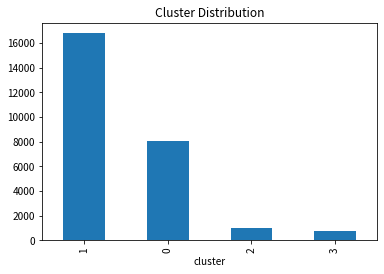

In [13]:
print(member_df['cluster'].value_counts())
member_df['cluster'].value_counts().plot(kind='bar', title='Cluster Distribution')

In [14]:
member_df

,MemberID,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess,cluster
0,GhKK5xXtrl1ZjIyXUY7Qr5hRqMwkbLvwMFqEObZ2oeI=,363.815400,1.397999e+03,21.769231,9.0,3.769231,1.285714,3012.7180,2983.3570,34.4870,0.181818,1.000000,846.436320,1
1,BEE1QykNZUQ6VNPmnkoPv7Ry34rSi24eQAtlDacWUJc=,337607.951000,3.376080e+05,5.952381,4.0,0.523810,1.000000,477.8220,322.6850,155.1370,0.250000,2.000000,NaN,1
2,XJXKHR+cTo9cwinRalfkVOvshVhvNtw+SzZ5WPme5+0=,61.668167,3.700090e+02,12.166667,10.5,2.833333,0.400000,672.0330,669.3110,2.7220,0.166667,1.125000,0.000000,1
3,WRy4jrS8JIRXqYXZdybGv/w702dnGrxYQzcEgmfCzN8=,12.232105,8.075800e+01,11.761905,8.0,2.714286,1.428571,827.7020,775.6990,7.5420,0.066667,1.000000,0.000000,1
4,CHL7cDPUa1iy/mwfOokQOFQ/iCExGp/RpWr4xh/ZB5M=,99.733385,1.209517e+03,41.000000,41.0,21.000000,0.750000,1480.0025,1472.0495,6.7085,2.000000,1.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26593,yNBuS+pj8BeUnvD0a3641B/WuQiQ7CfDc08r3ZPZQ/A=,329397.730604,1.021081e+07,21.423729,10.0,4.328814,0.706806,59045.6580,41109.8115,39.3370,0.210526,1.432049,814.492473,0
26594,9hMBEuoZHPm0KheEgqtLkvextSbsG18yVG/kU0BNRqc=,4.174727,4.592200e+01,8.235294,4.0,1.411765,0.125000,NaN,NaN,NaN,0.125000,1.000000,NaN,1
26595,YdCXdhtOGdHFm3k6ddxfJEKAMEqicfs9ItIEg+t02Do=,10.783957,1.599910e+02,9.809524,6.0,3.142857,1.153846,472.5845,437.7870,22.4935,4.000000,1.000000,455.088636,1
26596,ArNx5xzqOKsi03eEIMoFY4OgncNy4OBFz+blij7hLK0=,865152.719600,8.650766e+06,12.769231,6.0,2.384615,2.000000,1386.7875,327.6050,68.5250,0.428571,1.153846,517.952287,0


In [16]:
# save member_df with clusters
member_df.to_csv(f'{DATA_DIR}/Member_cluster.csv', index=False)

### 3. 分群之後：觀察不同群體，在各個 features 的差異

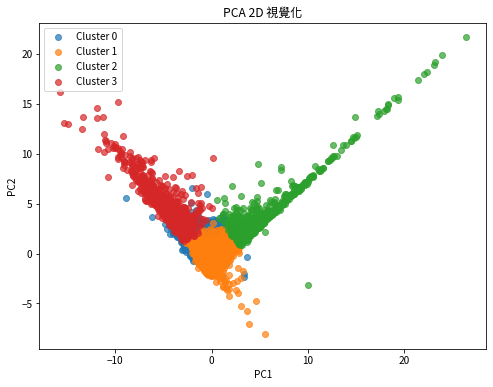

In [17]:
# PCA, t-SNE 視覺化
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled_df)

plt.figure(figsize=(8,6))
for cluster_id in sorted(member_df['cluster'].unique()):
    plt.scatter(
        pca_result[member_df['cluster'] == cluster_id, 0],
        pca_result[member_df['cluster'] == cluster_id, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.7
    )
plt.title('PCA 2D 視覺化')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [18]:
# 跑不動
#from sklearn.manifold import TSNE
#
## perplexity <= samples
#tsne = TSNE(n_components=2, random_state=42, perplexity=30)
#tsne_result = tsne.fit_transform(X_scaled_df)
#
#plt.figure(figsize=(8,6))
#for cluster_id in sorted(member_df['cluster'].unique()):
#    plt.scatter(
#        tsne_result[member_df['cluster'] == cluster_id, 0],
#        tsne_result[member_df['cluster'] == cluster_id, 1],
#        label=f'Cluster {cluster_id}',
#        alpha=0.7
#    )
#plt.title('t-SNE 2D 視覺化')
#plt.xlabel('t-SNE 1')
#plt.ylabel('t-SNE 2')
#plt.legend()
#plt.show()

In [19]:
# 看各個群的平均值
cluster_summary = X_noinf.copy()  # X_scaled_df
cluster_summary['cluster'] = member_df['cluster']
group_means = cluster_summary.groupby('cluster').mean()

display(group_means)

cluster_summary = X_scaled_df.copy()  # 
cluster_summary['cluster'] = member_df['cluster']
group_means = cluster_summary.groupby('cluster').mean()

display(group_means)

,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
cluster,,,,,,,,,,,,
0,7.134347e+05,9.267337e+06,14.454003,7.123213,3.516857,0.610407,3.156814e+05,2.146243e+05,1.803427e+04,0.328761,1.545431,259.282697
1,7.128817e+04,9.384619e+05,14.042378,6.792853,3.713080,0.814306,9.255551e+04,8.638788e+04,-1.081361e+04,0.430639,1.253818,125.327720
2,1.178342e+05,1.487973e+06,48.716375,37.351431,19.428328,0.776994,5.348072e+04,7.310338e+04,-1.632186e+04,0.863579,1.168387,164.047080
3,2.407970e+06,9.343165e+06,11.846030,7.205452,2.756901,0.834732,5.868189e+06,4.271291e+06,1.209960e+06,0.424558,1.791370,122.901560


,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
cluster,,,,,,,,,,,,
0,0.536536,1.221879,-0.094440,-0.108596,-0.156132,-0.242796,-0.010324,-0.031425,-0.023376,-0.145231,0.488735,0.319785
1,-0.369825,-0.611217,-0.134461,-0.146558,-0.112883,0.107321,-0.188895,-0.156899,-0.061839,0.024081,-0.255551,-0.145527
2,-0.304127,-0.490275,3.236797,3.364956,3.350880,0.043251,-0.224714,-0.173613,-0.071431,0.743590,-0.473595,-0.014996
3,2.928294,1.238568,-0.348006,-0.099146,-0.323632,0.142395,4.630599,4.073077,1.726923,0.013974,1.116445,-0.150855


In [ ]:
# TODO: 分群後的特徵解釋
# 0: 亂買 purchase_randomess 高、average_product view_max 高、buy_addCart_ratio 低、dicount_sensitivity 高
# 1: 買買買 purchase_randomess 低、buy_addCart_ratio 高、view_to_buy_duration_median 低、average_product_view_mean 低
# 2: 狂戳 session_count_mean 高, view_to_buy_duration_median 低
# 3: 猶豫 average_product_view_mean 高 只看不買 view_to_buy_duration_median 高、view_to_buy_duration_mean 高、dicount_sensitivity 高、buy_addCart_ratio 高

In [20]:
# random forest 切 0.8, 0.2 看看
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, member_df['cluster'], test_size=0.2, random_state=42
)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1614
           1       0.98      0.99      0.98      3337
           2       0.99      0.93      0.96       202
           3       0.97      0.91      0.94       167

    accuracy                           0.98      5320
   macro avg       0.98      0.95      0.96      5320
weighted avg       0.98      0.98      0.98      5320

Confusion Matrix:
[[1566   44    1    3]
 [  43 3291    1    2]
 [   4   10  188    0]
 [  13    2    0  152]]


In [21]:
# 做 random forest feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled_df, member_df['cluster'])
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_scaled_df.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print("Feature importances from Random Forest:")
display(importance_df)

Feature importances from Random Forest:


,feature,importance
1,average_product view_max,0.430398
0,average_product_view_mean,0.212710
10,come_back,0.067213
6,view_to_buy_duration_median,0.050605
3,session_count_median,0.049795
4,session_product_count,0.047289
7,add_to_buy_duration_median,0.039422
2,session_count_mean,0.038441
11,purchase_randomess,0.028917
5,buy_addCart_ratio,0.012975


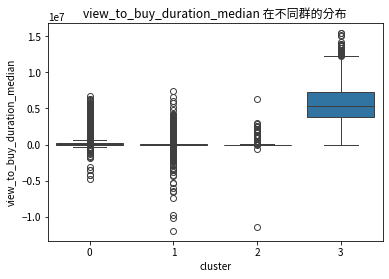

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 分群與數值特徵分佈視覺化
col_name = 'view_to_buy_duration_median'
sns.boxplot(x='cluster', y=f'{col_name}', data=member_df)
plt.title(f'{col_name} 在不同群的分布')
plt.show()

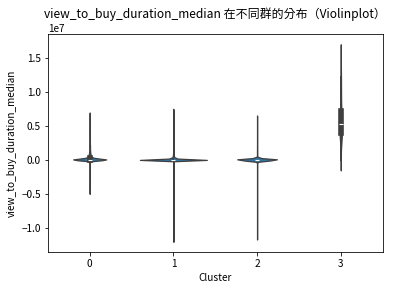

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(x='cluster', y=f'{col_name}', data=member_df)
plt.title(f'{col_name} 在不同群的分布（Violinplot）')
plt.xlabel('Cluster')
plt.ylabel(f'{col_name}')
plt.show()


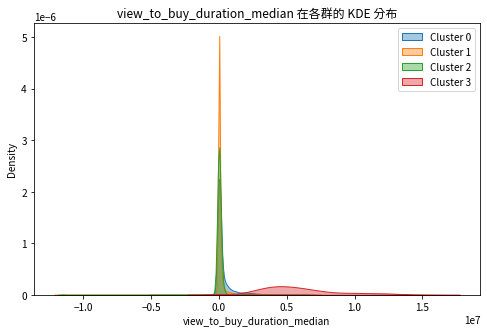

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

col_name = 'view_to_buy_duration_median'
plt.figure(figsize=(8, 5))

# 逐群畫出 KDE
for cluster_id in sorted(member_df['cluster'].unique()):
    sns.kdeplot(
        data=member_df[member_df['cluster'] == cluster_id][f'{col_name}'],
        label=f'Cluster {cluster_id}',
        fill=True, common_norm=False, alpha=0.4  # 不強制正規化喔
    )

plt.title(f'{col_name} 在各群的 KDE 分布')
plt.xlabel(f'{col_name}')
plt.ylabel('Density')
plt.legend()
plt.show()

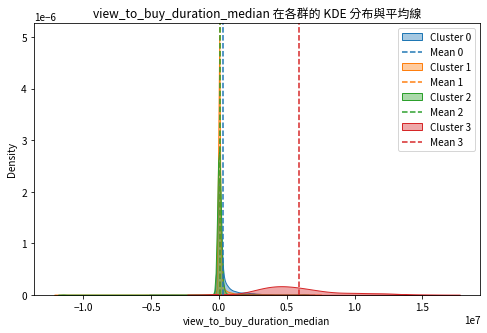

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

col_name = 'view_to_buy_duration_median'
plt.figure(figsize=(8, 5))

# 依群畫 KDE 並加上平均線
for cluster_id in sorted(member_df['cluster'].unique()):
    cluster_data = member_df[member_df['cluster'] == cluster_id][f'{col_name}']
    sns.kdeplot(cluster_data, label=f'Cluster {cluster_id}', fill=True, common_norm=False, alpha=0.4)

    # 加上平均值垂直線
    mean_val = cluster_data.mean()
    plt.axvline(mean_val, linestyle='--', linewidth=1.5, label=f'Mean {cluster_id}', color=f'C{cluster_id}')

plt.title(f'{col_name} 在各群的 KDE 分布與平均線')
plt.xlabel(f'{col_name}')
plt.ylabel('Density')
plt.legend()
plt.show()

### 4. (merge 會員、子單、商品) 抓出不同群會員的商品
- 將商品標註會員群，一個商品可能有多個群

#### 不要看，這裡會 access 到大資料

In [ ]:
ODER_DIR = '/Volumes/PNYPROELITE/mo/bda/data/NOmceSRCGAE2GjCOCwaCrA==/OrderTS_Chunks'
# 在 all 子單中，抓出所有「要分析的會員」的子單資料
for i in range(1, 5, 1):
    order_df = pd.read_parquet(f'{ODER_DIR}/chunk_{i}.parquet')
    print(f'chunk_{i}.parquet (before):', order_df.shape)
    order_df = order_df[order_df['ShopMemberId'].isin(member_ids)]
    print(f'chunk_{i}.parquet (after):', order_df.shape)
    display(order_df.head(1))
    order_df.to_parquet(f'{DATA_DIR}/order_chunk_{i}.parquet', index=False)

chunk_1.parquet (before): (2730021, 21)
chunk_1.parquet (after): (533752, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
14553060,NOmceSRCGAE2GjCOCwaCrA==,Femls6ZrSM/Gl474V9HIfY8tmg4ABCg3eBKxAgRtTDk=,zTPlj+NyscXqrBmmIZZoKQ==,JUlFLFNqhLHY0mvpryCxAg==,2022-09-26 13:01:54.530,2022-10-01 11:46:16.520,OfficialECom,iOSApp,CreditCardOnce,LocationPickup,...,g3ZELDd9Kbed2V/Qp2K4zw==,7276346.0,1,90.0,45.0,90.0,0.0,-45.0,0.0,Finish


chunk_2.parquet (before): (124299, 21)
chunk_2.parquet (after): (16585, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
20000002,NOmceSRCGAE2GjCOCwaCrA==,EsPTBN97H9IqUwO4/0zWq6GlT1H9I2fL+jYKfk6iFFE=,/gbW0jkOMwc4BaHFJ8v5XA==,owxzGHQb9GbrTTZIhJCzZA==,2022-10-04 12:15:38.307,2022-10-05 01:06:08.533,OfficialECom,DesktopOfficialWeb,EasyWallet,Home,...,YT6zlMpyPI5YFD818sV/EA==,7235118.0,1,99.0,79.0,99.0,0.0,-19.0,-1.0,Finish


chunk_3.parquet (before): (1115622, 21)
chunk_3.parquet (after): (322332, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
35821974,NOmceSRCGAE2GjCOCwaCrA==,JMOd+0yolInkurgOI6TeWFk/FxDrwSkZiXHjZCp4ua8=,kvAzQJPPysCMgKx99s5x6w==,PvVC+xEHsVnEZULOIhRyAg==,2023-05-04 10:12:44.237,2023-05-04 10:12:44.267,OfficialECom,iOSApp,CreditCardOnce,Home,...,72EUVNUWwwxTlFqAw6FF+w==,7610173.0,1,69.0,58.0,69.0,0.0,-11.0,0.0,Fail


chunk_4.parquet (before): (1581096, 21)
chunk_4.parquet (after): (509005, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
40000014,NOmceSRCGAE2GjCOCwaCrA==,qvu6wYM3jN+B6stq0ffUijeHAeQJGoPsFD4uVh0zxkA=,Li9vQUStwNlb1J9YmST4Ew==,Y6RkU5zPOcXrNZZH/A9YzA==,2023-08-31 11:45:37.017,2023-08-31 22:35:10.813,N1Shopping,iOSApp,LinePay,Home,...,l5F6MgdIaau4F2FdTGLeEg==,8924965.0,1,0.0,0.0,0.0,0.0,0.0,0.0,Finish


In [22]:
# 在「要分析的會員」子單中，抓出「在行為期間內」的子單資料
order_df = pd.concat([pd.read_parquet(f'{DATA_DIR}/order_chunk_{i}.parquet') for i in range(1, 5, 1)], ignore_index=True)
print("Total order_df (before):", order_df.shape)

order_df = order_df[order_df['OrderDateTime'] >= '2023-09-01']  # assume session 是從 2023-09-01 開始的
order_df['SalePageId'] = order_df['SalePageId'].astype(float).astype(int)  # 把 SalePageId 轉成 int（先轉 float，再轉 int）
print("Total order_df (after):", order_df.shape)
display(order_df.head(1))
order_df.to_parquet(f'{DATA_DIR}/Order.parquet', index=False)

Total order_df (before): (1381674, 21)
Total order_df (after): (577680, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
550338,NOmceSRCGAE2GjCOCwaCrA==,6iNg/HozeX6XsOFy3Xw6SZNgIrFKV+D51VojSWNKg40=,o/bU8miBiMvPh8kyuHQ2/g==,JvkvUrRNzUKB32osycPevw==,2023-12-28 22:21:16.380,2023-12-29 10:35:10.357,N1Shopping,iOSApp,LinePay,Home,...,O65U++lx47sXOLohhXBNqw==,7273062,1,39.0,39.0,39.0,0.0,0.0,0.0,Finish


#### 看子單：依據子單，將會員分群媒合到商品

In [23]:
order_df = pd.read_parquet(f'{DATA_DIR}/Order.parquet')
print("Total order_df:", order_df.shape)
display(order_df.head(1))

Total order_df: (577680, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
0,NOmceSRCGAE2GjCOCwaCrA==,6iNg/HozeX6XsOFy3Xw6SZNgIrFKV+D51VojSWNKg40=,o/bU8miBiMvPh8kyuHQ2/g==,JvkvUrRNzUKB32osycPevw==,2023-12-28 22:21:16.380,2023-12-29 10:35:10.357,N1Shopping,iOSApp,LinePay,Home,...,O65U++lx47sXOLohhXBNqw==,7273062,1,39.0,39.0,39.0,0.0,0.0,0.0,Finish


In [24]:
order_df['StatusDef'].value_counts()

StatusDef
Finish     475553
Cancel      75413
Fail        20300
Overdue      2655
Return       2205
New          1554
Name: count, dtype: int64

In [26]:
# 1. 將 cluster 合併到 order_df
order_df = order_df.rename(columns={'ShopMemberId': 'MemberID'})
order_with_cluster = order_df.merge(member_df[['MemberID', 'cluster']], on='MemberID', how='left')

# 2. 為每筆購買標記為 1（計數用）
order_with_cluster['purchase'] = 1

# 3. 透過 pivot_table 對 goodsID 做 cluster 統計
cluster_pivot = order_with_cluster.pivot_table(
    index='SalePageId',
    columns='cluster',
    values='purchase',
    aggfunc='sum',
    fill_value=0  # 沒有購買就補 0
)

# 4. 重命名欄位
cluster_pivot.columns = [f'cluster{int(col)}' for col in cluster_pivot.columns]

# 5. Reset index 讓 goodsID 變回欄位
result_df = cluster_pivot.reset_index()

# 6. 顯示結果
display(result_df)

,SalePageId,cluster0,cluster1,cluster2,cluster3
0,7041900,10,9,0,1
1,7041901,64,79,3,0
2,7041902,0,1,0,0
3,7041903,7,10,1,0
4,7041904,4,3,0,0
...,...,...,...,...,...
18588,9579119,0,2,0,0
18589,9579174,0,0,2,0
18590,9579192,0,2,0,0
18591,9579234,0,4,0,0


In [27]:
# 計算一個商品會屬於幾種 cluster（>= 5 才算）
result_df['num_clusters'] = result_df[[col for col in result_df.columns if col.startswith('cluster')]].apply(lambda x: (x >= 5).sum(), axis=1)

# 7. 顯示每個商品屬於幾種 cluster
print("每個商品屬於幾種 cluster:")
result_df['num_clusters'].value_counts() #.sort_index().plot(kind='bar', title='Number of Clusters per Product')

每個商品屬於幾種 cluster:


num_clusters
0    9431
2    4375
1    3586
3     951
4     250
Name: count, dtype: int64

In [30]:
# 取出不同 cluster 的商品 ids
cluster_goods = {}
for cluster_id in range(4):
    cluster_col = f'cluster{cluster_id}'
    cluster_goods[cluster_col] = result_df[result_df[cluster_col] >= 5]['SalePageId'].tolist()
    print(f"Cluster {cluster_id} 商品數量:", len(cluster_goods[cluster_col]))

# 儲存每個 cluster 的商品 ids
with open(f'{DATA_DIR}/cluster_goods.json', 'w') as f:
    json.dump(cluster_goods, f, indent=4)

Cluster 0 商品數量: 7485
Cluster 1 商品數量: 7123
Cluster 2 商品數量: 1072
Cluster 3 商品數量: 509


In [5]:
# 讀取儲存的 cluster 商品 ids
with open(f'{DATA_DIR}/cluster_goods.json', 'r') as f:
    cluster_goods = json.load(f)

# 顯示每個 cluster 的商品 ids
for cluster_id, goods in cluster_goods.items():
    print(f"{cluster_id} 商品數量:", len(goods))
    print(f"{cluster_id} 商品 ids:", goods[:10])  # 只顯示前 10 個商品 id

cluster0 商品數量: 7485
cluster0 商品 ids: [7041900, 7041901, 7041903, 7041905, 7041907, 7041914, 7041915, 7041918, 7041921, 7041922]
cluster1 商品數量: 7123
cluster1 商品 ids: [7041900, 7041901, 7041903, 7041905, 7041907, 7041910, 7041915, 7041918, 7041921, 7041929]
cluster2 商品數量: 1072
cluster2 商品 ids: [7042109, 7044507, 7044510, 7044515, 7044517, 7044526, 7044528, 7044539, 7044703, 7044708]
cluster3 商品數量: 509
cluster3 商品 ids: [7044333, 7044490, 7044725, 7044759, 7044960, 7044968, 7046067, 7046072, 7046076, 7046083]


### 5. 依據「商品描述」抓關鍵字

In [9]:
# load cluster 商品 ids
with open(f'{DATA_DIR}/cluster_goods.json', 'r') as f:
    cluster_goods = json.load(f)

# show 不同 cluster 的商品 ids
for cluster_id, goods in cluster_goods.items():
    print(f"{cluster_id} 商品數量:", len(goods))
    print(f"{cluster_id} 商品 ids:", goods[:10])  # 只顯示前 10 個商品 id

cluster0 商品數量: 7485
cluster0 商品 ids: [7041900, 7041901, 7041903, 7041905, 7041907, 7041914, 7041915, 7041918, 7041921, 7041922]
cluster1 商品數量: 7123
cluster1 商品 ids: [7041900, 7041901, 7041903, 7041905, 7041907, 7041910, 7041915, 7041918, 7041921, 7041929]
cluster2 商品數量: 1072
cluster2 商品 ids: [7042109, 7044507, 7044510, 7044515, 7044517, 7044526, 7044528, 7044539, 7044703, 7044708]
cluster3 商品數量: 509
cluster3 商品 ids: [7044333, 7044490, 7044725, 7044759, 7044960, 7044968, 7046067, 7046072, 7046076, 7046083]


#### 5-1. BERT

In [ ]:
# load lib
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = '/kaggle/input/bda-proj-data'
DATA2_DIR = '/kaggle/input/bda-proj-data2'

In [ ]:
# load cluster 商品 ids
with open(f'{DATA_DIR}/cluster_goods.json', 'r') as f:
    cluster_goods = json.load(f)

# show 不同 cluster 的商品 ids
for cluster_id, goods in cluster_goods.items():
    print(f"{cluster_id} 商品數量:", len(goods))
    print(f"{cluster_id} 商品 ids:", goods[:10])  # 只顯示前 10 個商品 id

cluster0 商品數量: 7485
cluster0 商品 ids: [7041900, 7041901, 7041903, 7041905, 7041907, 7041914, 7041915, 7041918, 7041921, 7041922]
cluster1 商品數量: 7123
cluster1 商品 ids: [7041900, 7041901, 7041903, 7041905, 7041907, 7041910, 7041915, 7041918, 7041921, 7041929]
cluster2 商品數量: 1072
cluster2 商品 ids: [7042109, 7044507, 7044510, 7044515, 7044517, 7044526, 7044528, 7044539, 7044703, 7044708]
cluster3 商品數量: 509
cluster3 商品 ids: [7044333, 7044490, 7044725, 7044759, 7044960, 7044968, 7046067, 7046072, 7046076, 7046083]


In [ ]:
# load 商品 bert vec
bert_df = pd.read_csv(f'{DATA2_DIR}/SalePage_bertvecs.csv')
display(bert_df.head(1))

,SalePageId,title_bertvecs,desc_bertvecs,all_bertvecs
0,7104874,[-5.49720049e-01 1.68619961e-01 -8.99275541e-...,[ 1.14451170e-01 3.34259242e-01 -3.35280836e-...,[-5.49720049e-01 1.68619961e-01 -8.99275541e-...


In [ ]:
# 將 bert_df 依據 cluster_goods 分組
cluster_goods_df = {}
for cluster_col, goods_ids in cluster_goods.items():
    cluster_goods_df[cluster_col] = bert_df[bert_df['SalePageId'].isin(goods_ids)].copy()
    cluster_goods_df[cluster_col]['cluster'] = cluster_col

for cluster_col, df in cluster_goods_df.items():
    print(f"Cluster {cluster_col} 商品數量:", df.shape[0])
    display(df.head(1))
    # 儲存到 CSV
    #df.to_csv(f'{DATA_DIR}/{cluster_col}_goods.csv', index=False)

Cluster cluster0 商品數量: 7485


,SalePageId,title_bertvecs,desc_bertvecs,all_bertvecs,cluster
2,7098402,[ 6.40155375e-01 2.33248681e-01 -7.01356947e-...,[ 1.04694223e+00 3.87665369e-02 4.56350386e-...,[ 7.89127409e-01 2.34055612e-02 -2.12740257e-...,cluster0


Cluster cluster1 商品數量: 7123


,SalePageId,title_bertvecs,desc_bertvecs,all_bertvecs,cluster
2,7098402,[ 6.40155375e-01 2.33248681e-01 -7.01356947e-...,[ 1.04694223e+00 3.87665369e-02 4.56350386e-...,[ 7.89127409e-01 2.34055612e-02 -2.12740257e-...,cluster1


Cluster cluster2 商品數量: 1072


,SalePageId,title_bertvecs,desc_bertvecs,all_bertvecs,cluster
2,7098402,[ 6.40155375e-01 2.33248681e-01 -7.01356947e-...,[ 1.04694223e+00 3.87665369e-02 4.56350386e-...,[ 7.89127409e-01 2.34055612e-02 -2.12740257e-...,cluster2


Cluster cluster3 商品數量: 509


,SalePageId,title_bertvecs,desc_bertvecs,all_bertvecs,cluster
26,9207710,[-7.77525380e-02 3.92218649e-01 -9.69609439e-...,[ 1.14451170e-01 3.34259242e-01 -3.35280836e-...,[-7.77525380e-02 3.92218649e-01 -9.69609439e-...,cluster3


In [ ]:
# 準備 PCA
# 合併所有 cluster 並加上 cluster label
all_df = []
for cluster_col, df in cluster_goods_df.items():
    df = df.copy()
    df['cluster'] = cluster_col  # 加入群組標籤
    all_df.append(df)

combined_df = pd.concat(all_df, ignore_index=True)

# 將每個字串向量轉為 numpy array
def parse_vec(s):
    return np.fromstring(s.strip('[]'), sep=' ')

# PCA f.
def doPCA(combined_df, col_name):
    # BERT str --> std(BERT vec)
    X = np.vstack(combined_df[f'{col_name}'].apply(parse_vec).values)  # shape: (N, 768)
    X_scaled = StandardScaler().fit_transform(X)

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    
    # 把 PCA 結果加回原 df
    combined_df['pca1'] = pca_result[:, 0]
    combined_df['pca2'] = pca_result[:, 1]

    # draw
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=combined_df, x='pca1', y='pca2', hue='cluster', palette='tab10', alpha=0.7)
    plt.title(f'PCA of {col_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()
    return

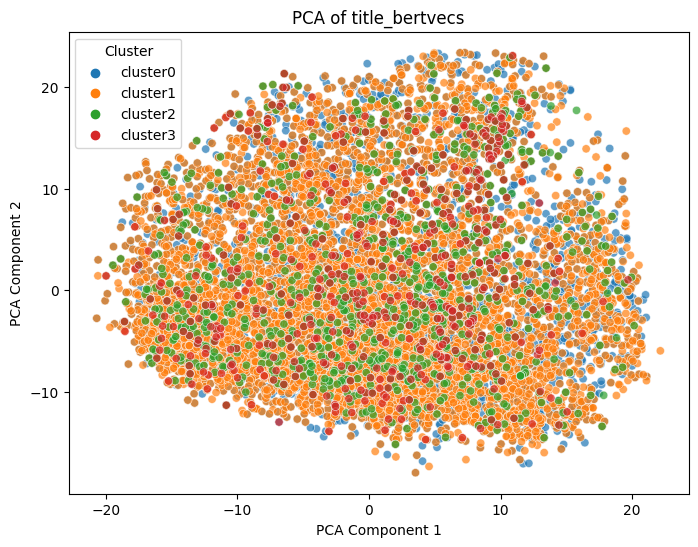

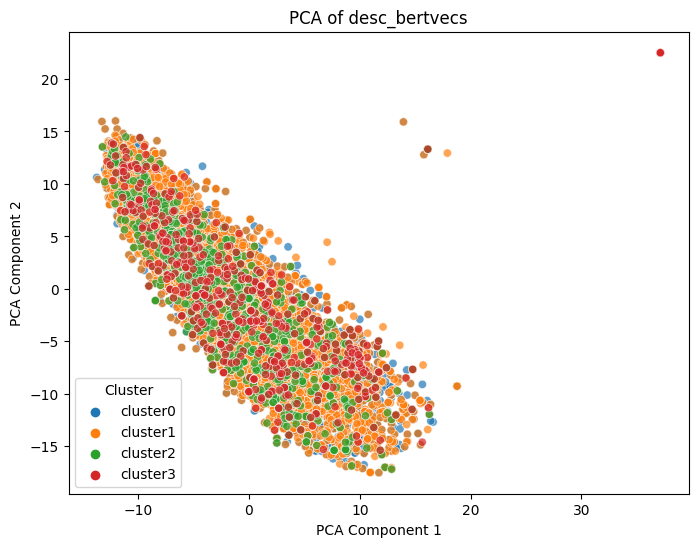

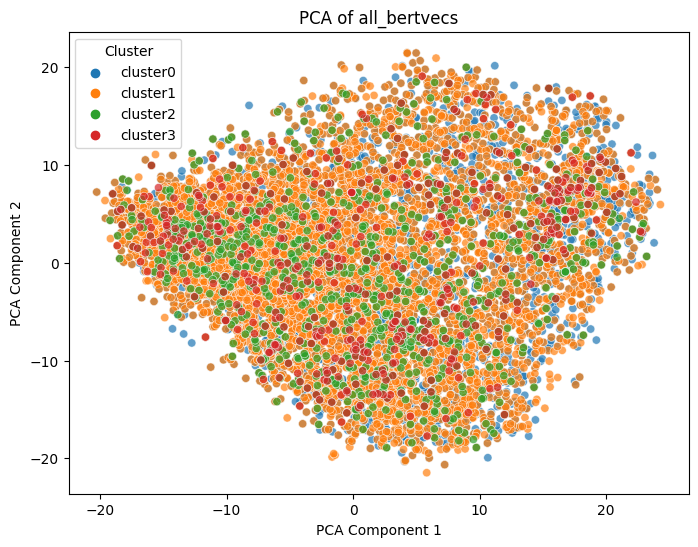

In [ ]:
doPCA(combined_df, 'title_bertvecs')
doPCA(combined_df, 'desc_bertvecs')
doPCA(combined_df, 'all_bertvecs')

In [ ]:
# t-SNE f.
def doTSNE(combined_df, col_name):
    # BERT str --> std(BERT vec)
    X = np.vstack(combined_df[f'{col_name}'].apply(parse_vec).values)  # shape: (N, 768)
    X_scaled = StandardScaler().fit_transform(X)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(X_scaled)
    
    # 把 t-SNE 結果加回原 df
    combined_df['tsne1'] = tsne_result[:, 0]
    combined_df['tsne2'] = tsne_result[:, 1]
    
    # draw
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=combined_df, x='tsne1', y='tsne2', hue='cluster', palette='tab10', alpha=0.7)
    plt.title(f't-SNE of {col_name}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()
    return

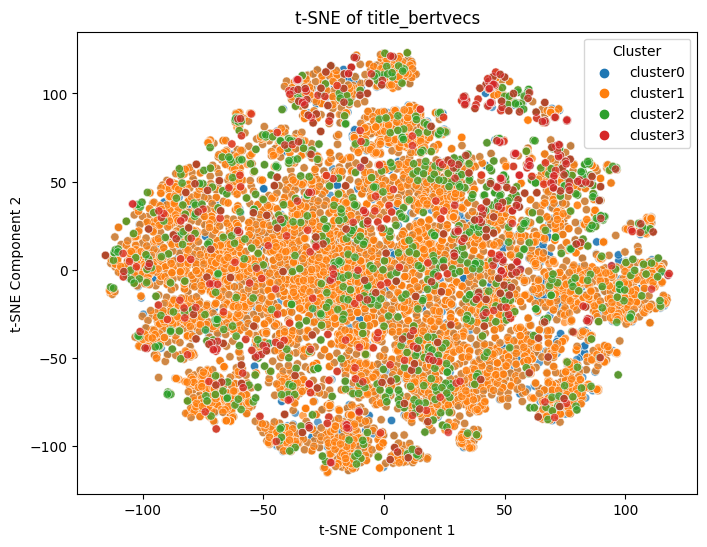

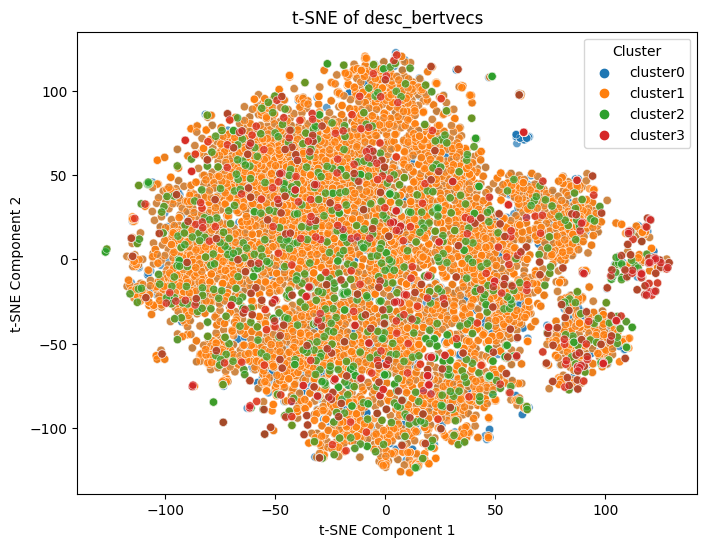

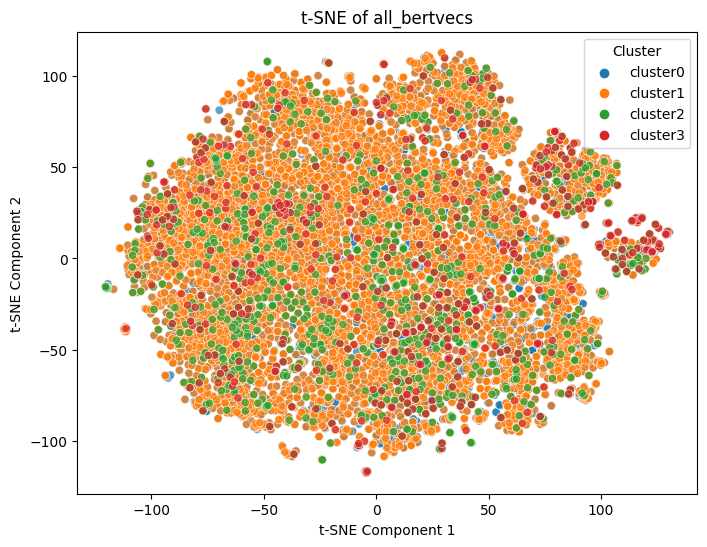

In [ ]:
doTSNE(combined_df, 'title_bertvecs')
doTSNE(combined_df, 'desc_bertvecs')
doTSNE(combined_df, 'all_bertvecs')

#### 5-2. TF-IDF

In [10]:
# load cut terms
salepage_terms_df = pd.read_csv(f'{DATA_DIR}/SalePage_cutterms.csv')
print("salepage_terms_df", salepage_terms_df.shape)
salepage_terms_df.fillna({'title_cutterms': '', 'desc_cutterms':''}, inplace=True)  # 填補 NaN
salepage_terms_df['all_cutterms'] = salepage_terms_df['title_cutterms'] + ' ' + salepage_terms_df['desc_cutterms']
display(salepage_terms_df.head(1))

salepage_terms_df (46245, 3)


,SalePageId,title_cutterms,desc_cutterms,all_cutterms
0,7104874,戰神 mars 搖搖杯 ml 夜幕 黑,,戰神 mars 搖搖杯 ml 夜幕 黑


In [11]:
# 將 salepage_terms_df 依據 cluster_goods 分組
cluster_goodsTerms_df = {}
for cluster_col, goods_ids in cluster_goods.items():
    cluster_goodsTerms_df[cluster_col] = salepage_terms_df[salepage_terms_df['SalePageId'].isin(goods_ids)].copy()
    cluster_goodsTerms_df[cluster_col]['cluster'] = cluster_col

for cluster_col, df in cluster_goodsTerms_df.items():
    print(f"Cluster {cluster_col} 商品數量:", df.shape[0])
    display(df.head(1))

Cluster cluster0 商品數量: 7485


,SalePageId,title_cutterms,desc_cutterms,all_cutterms,cluster
2,7098402,曼寧 健康 花草茶 入 多 款 任選,優雅 清香 的 玫瑰 花茶 養顏 美容 散發出 迷人 香氣 進口 德國 花草 原料 品...,曼寧 健康 花草茶 入 多 款 任選 優雅 清香 的 玫瑰 花茶 養顏 美容 散發出 迷...,cluster0


Cluster cluster1 商品數量: 7123


,SalePageId,title_cutterms,desc_cutterms,all_cutterms,cluster
2,7098402,曼寧 健康 花草茶 入 多 款 任選,優雅 清香 的 玫瑰 花茶 養顏 美容 散發出 迷人 香氣 進口 德國 花草 原料 品...,曼寧 健康 花草茶 入 多 款 任選 優雅 清香 的 玫瑰 花茶 養顏 美容 散發出 迷...,cluster1


Cluster cluster2 商品數量: 1072


,SalePageId,title_cutterms,desc_cutterms,all_cutterms,cluster
2,7098402,曼寧 健康 花草茶 入 多 款 任選,優雅 清香 的 玫瑰 花茶 養顏 美容 散發出 迷人 香氣 進口 德國 花草 原料 品...,曼寧 健康 花草茶 入 多 款 任選 優雅 清香 的 玫瑰 花茶 養顏 美容 散發出 迷...,cluster2


Cluster cluster3 商品數量: 509


,SalePageId,title_cutterms,desc_cutterms,all_cutterms,cluster
26,9207710,bodygoals 多效 乳 清蛋 白飲 g 英式 奶茶,,bodygoals 多效 乳 清蛋 白飲 g 英式 奶茶,cluster3


In [28]:
# TF-IDF 抓出每個 cluster 的關鍵詞
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()  # max_features=1000 限制最多 1000 個特徵
vectorizer.fit(salepage_terms_df['all_cutterms'])

def get_top_keywords(df, cluster_col, top_n=10):
    tfidf_matrix = vectorizer.transform(df['all_cutterms'])
    
    feature_names = vectorizer.get_feature_names_out()
    
    # 計算每個 cluster 的平均 TF-IDF
    avg_tfidf = np.mean(tfidf_matrix.toarray(), axis=0)
    
    # 取得 top N 關鍵詞
    top_indices = np.argsort(avg_tfidf)[-top_n:][::-1]
    top_keywords = [(feature_names[i], avg_tfidf[i]) for i in top_indices]
    
    return top_keywords

# 取得每個 cluster 的 top 100 關鍵詞
top_keywords = {}
for cluster_col, df in cluster_goodsTerms_df.items():
    top_keywords[cluster_col] = get_top_keywords(df, cluster_col, top_n=100)
    print(f"Cluster {cluster_col} Top Keywords:")
    for keyword, score in top_keywords[cluster_col]:
        print(f"{keyword}: {score:.4f}")
    print()

Cluster cluster0 Top Keywords:
肌膚: 0.0287
ml: 0.0232
保濕: 0.0191
添加: 0.0171
任選: 0.0133
配方: 0.0131
成分: 0.0122
修護: 0.0118
精華: 0.0113
舒適: 0.0109
設計: 0.0107
贈品: 0.0104
使用: 0.0099
有效: 0.0096
溫和: 0.0096
抗菌: 0.0095
舒緩: 0.0094
天然: 0.0093
cm: 0.0092
清爽: 0.0087
細緻: 0.0086
玻尿酸: 0.0085
清潔: 0.0081
包裝: 0.0081
日本: 0.0076
隨機: 0.0075
萃取: 0.0075
毛孔: 0.0075
潔淨: 0.0074
頭皮: 0.0073
柔軟: 0.0073
深層: 0.0072
清新: 0.0072
香氛: 0.0072
出貨: 0.0070
自然: 0.0068
安心: 0.0068
吸收: 0.0065
健康: 0.0064
輕鬆: 0.0064
滋潤: 0.0064
幫助: 0.0062
不易: 0.0061
完美: 0.0061
透氣: 0.0059
面膜: 0.0057
快速: 0.0057
維持: 0.0057
維他命: 0.0056
升級: 0.0055
乾爽: 0.0055
親膚: 0.0055
精油: 0.0055
秀髮: 0.0054
長效: 0.0054
彈性: 0.0054
角質: 0.0054
材質: 0.0054
適用: 0.0053
入點: 0.0052
效果: 0.0052
高效: 0.0052
刺激: 0.0051
打造: 0.0051
洗淨: 0.0051
深入: 0.0049
玫瑰: 0.0049
預防: 0.0048
植物: 0.0048
改善: 0.0048
乾燥: 0.0048
彈力: 0.0048
水潤: 0.0048
補充: 0.0047
因子: 0.0047
潤澤: 0.0047
方便: 0.0047
韓國: 0.0046
台灣: 0.0046
觸感: 0.0045
保護: 0.0045
沐浴: 0.0045
質地: 0.0044
黏膩: 0.0044
提升: 0.0044
蛋白: 0.0044
同時: 0.0044
減少: 0.0043

#### 5-3. 人工/智慧挑關鍵字

,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,SalePageText
0,NOmceSRCGAE2GjCOCwaCrA==,7104874,戰神MARS搖搖杯2.0-600ml-夜幕黑,NaN,戰神MARS搖搖杯2.0-600ml-夜幕黑
1,NOmceSRCGAE2GjCOCwaCrA==,7098357,國太樓伯爵紅茶 28.8g-蘋果風味,日本原裝進口,國太樓伯爵紅茶 28.8g-蘋果風味 日本原裝進口
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠,曼寧健康花草茶15入-多款任選 優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花...
3,NOmceSRCGAE2GjCOCwaCrA==,7048775,阿華田營養巧克力麥芽飲品 20g*13入,源自瑞士百年麥芽經典\n嚴選優質麥芽精華、濃郁可可及濃醇乳香\n兼顧健康與美味，完美調配營養...,阿華田營養巧克力麥芽飲品 20g*13入 源自瑞士百年麥芽經典\n嚴選優質麥芽精華、濃郁可可...
4,NOmceSRCGAE2GjCOCwaCrA==,7076969,曼寧有機蘋香舒緩茶20入,•晚餐後或睡前最好的舒眠飲品\n•帶有蘋果甜蜜香氣的洋甘菊\n•原料來自德國，品質令人信賴,曼寧有機蘋香舒緩茶20入 •晚餐後或睡前最好的舒眠飲品\n•帶有蘋果甜蜜香氣的洋甘菊\n•原...
...,...,...,...,...,...
46240,NOmceSRCGAE2GjCOCwaCrA==,9229146,贈-Biore淨嫩沐浴乳300g櫻花香,贈-Biore淨嫩沐浴乳300g櫻花香,贈-Biore淨嫩沐浴乳300g櫻花香 贈-Biore淨嫩沐浴乳300g櫻花香
46241,NOmceSRCGAE2GjCOCwaCrA==,9545749,2/28-3/05贈品-氧顏森活微分子乳木果保濕面膜3入,2/28-3/05贈品-氧顏森活微分子乳木果保濕面膜3入,2/28-3/05贈品-氧顏森活微分子乳木果保濕面膜3入 2/28-3/05贈品-氧顏森活微...
46242,NOmceSRCGAE2GjCOCwaCrA==,9370014,12/06-01/09門市取貨滿$590抽Apple Watch S9 LTE 41mm (...,12/06-01/09門市取貨滿$590抽Apple Watch S9 LTE 41mm (...,12/06-01/09門市取貨滿$590抽Apple Watch S9 LTE 41mm (...
46243,NOmceSRCGAE2GjCOCwaCrA==,9288119,【廠商直送】贈-ILOVEPINK抱枕-2入(顏色隨機出貨)-$799,【廠商直送】贈-ILOVEPINK抱枕-2入(顏色隨機出貨)-$799,【廠商直送】贈-ILOVEPINK抱枕-2入(顏色隨機出貨)-$799 【廠商直送】贈-IL...


title_length range 1 81


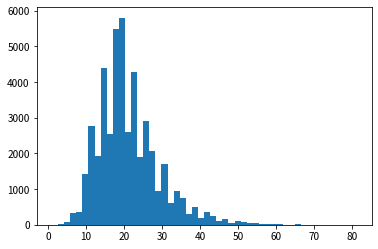

desc_length range 1.0 550.0


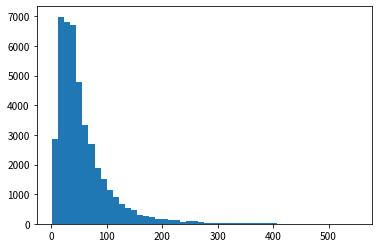

all_length range 3 575


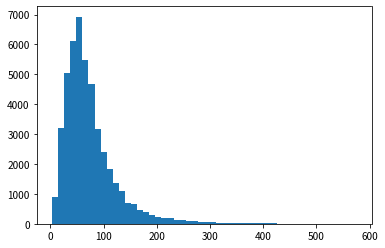

In [12]:
salepage_df = pd.read_csv(f'{DATA_DIR}/SalePage.csv')
salepage_df['SalePageText'] = salepage_df['SalePageTitle'].fillna('') + ' ' + salepage_df['SaleProductDescShortContent'].fillna('')  # 標題 + 敘述
display(salepage_df)

# SalePageTitle 字數分布
salepage_df['title_length'] = salepage_df['SalePageTitle'].str.len()
print("title_length range", salepage_df['title_length'].min(), salepage_df['title_length'].max())
plt.hist(salepage_df['title_length'], bins=50)
plt.show()

# SaleProductDescShortContent 字數分布
salepage_df['desc_length'] = salepage_df['SaleProductDescShortContent'].str.len()
print("desc_length range", salepage_df['desc_length'].min(), salepage_df['desc_length'].max())
plt.hist(salepage_df['desc_length'], bins=50)
plt.show()

# SalePageText 字數分布
salepage_df['all_length'] = salepage_df['SalePageText'].str.len()
print("all_length range", salepage_df['all_length'].min(), salepage_df['all_length'].max())
plt.hist(salepage_df['all_length'], bins=50)
plt.show()

In [13]:
# 將 sale_page_df 依據 cluster_goods 分組
cluster_goods_df = {}
for cluster_col, goods_ids in cluster_goods.items():
    cluster_goods_df[cluster_col] = salepage_df[salepage_df['SalePageId'].isin(goods_ids)].copy()
    cluster_goods_df[cluster_col]['cluster'] = cluster_col

for cluster_col, df in cluster_goods_df.items():
    print(f"Cluster {cluster_col} 商品數量:", df.shape[0])
    display(df.head(1))
    # 儲存到 CSV
    #df.to_csv(f'{DATA_DIR}/{cluster_col}_goods.csv', index=False)

Cluster cluster0 商品數量: 7485


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,SalePageText,title_length,desc_length,all_length,cluster
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠,曼寧健康花草茶15入-多款任選 優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花...,15,38.0,54,cluster0


Cluster cluster1 商品數量: 7123


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,SalePageText,title_length,desc_length,all_length,cluster
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠,曼寧健康花草茶15入-多款任選 優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花...,15,38.0,54,cluster1


Cluster cluster2 商品數量: 1072


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,SalePageText,title_length,desc_length,all_length,cluster
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠,曼寧健康花草茶15入-多款任選 優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花...,15,38.0,54,cluster2


Cluster cluster3 商品數量: 509


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,SalePageText,title_length,desc_length,all_length,cluster
26,NOmceSRCGAE2GjCOCwaCrA==,9207710,Bodygoals 多效乳清蛋白飲31g-英式奶茶,NaN,Bodygoals 多效乳清蛋白飲31g-英式奶茶,25,NaN,26,cluster3


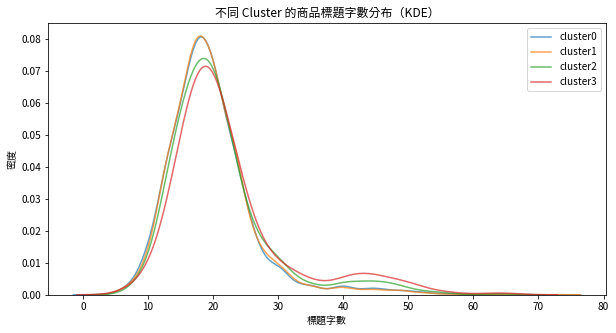

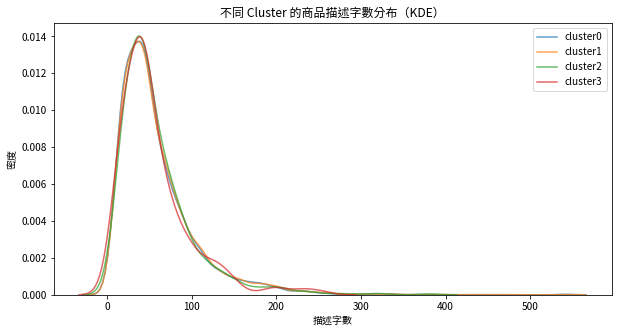

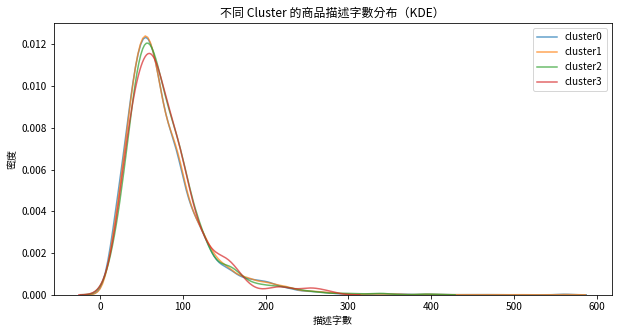

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# 商品標題字數 KDE 分布
plt.figure(figsize=(10, 5))
for cluster_col, df in cluster_goods_df.items():
    sns.kdeplot(df['title_length'], label=cluster_col, fill=False, alpha=0.7)
plt.title('不同 Cluster 的商品標題字數分布（KDE）')
plt.xlabel('標題字數')
plt.ylabel('密度')
plt.legend()
plt.show()

# 商品描述字數 KDE 分布
plt.figure(figsize=(10, 5))
for cluster_col, df in cluster_goods_df.items():
    sns.kdeplot(df['desc_length'], label=cluster_col, fill=False, alpha=0.7)
plt.title('不同 Cluster 的商品描述字數分布（KDE）')
plt.xlabel('描述字數')
plt.ylabel('密度')
plt.legend()
plt.show()

# 商品標題 + 字數 KDE 分布
plt.figure(figsize=(10, 5))
for cluster_col, df in cluster_goods_df.items():
    sns.kdeplot(df['all_length'], label=cluster_col, fill=False, alpha=0.7)
plt.title('不同 Cluster 的商品描述字數分布（KDE）')
plt.xlabel('描述字數')
plt.ylabel('密度')
plt.legend()
plt.show()

In [14]:
# '贈' 這個詞，出現在不同商品分群的比例
def calculate_term_proportions(term, cluster_goods_df):
    proportions = {}
    for cluster_col, df in cluster_goods_df.items():
        term_count = df['SalePageText'].str.contains(term).sum()
        total_count = df.shape[0]
        proportions[cluster_col] = term_count / total_count if total_count > 0 else 0
    return proportions
term = '限時' # 抽, '贈', '折', '免運', '滿額', '必買'
term_proportions = calculate_term_proportions(term, cluster_goods_df)
print(f"'{term}' 在不同 Cluster 的比例:")
for cluster_col, proportion in term_proportions.items():
    print(f"{cluster_col}: {proportion:.2%}")

'限時' 在不同 Cluster 的比例:
cluster0: 2.44%
cluster1: 2.11%
cluster2: 1.87%
cluster3: 1.18%


In [ ]:
# Cluster0 計畫購買型, 重視性價比、品質、比價資訊
# terms = 「高CP值」「精選評比」「耐用」「熱銷冠軍」「買過都說讚」「詳細規格」「同類最低價」「品質保證」
terms = ['高CP值', 'CP值', '精選', '評比', '耐用', '熱銷', '熱銷冠軍', '買過都說讚', '詳細規格', '規格', '詳細資訊', '同類最低價', '最低價', '全網最低價', '品質保證']
for term in terms:
    term_proportions = calculate_term_proportions(term, cluster_goods_df)
    print(f"\n'{term}' 在不同 Cluster 的比例:")
    for cluster_col, proportion in term_proportions.items():
        print(f"{cluster_col}: {proportion:.2%}")


'高CP值' 在不同 Cluster 的比例:
cluster0: 0.09%
cluster1: 0.06%
cluster2: 0.09%
cluster3: 0.00%

'CP值' 在不同 Cluster 的比例:
cluster0: 0.15%
cluster1: 0.10%
cluster2: 0.19%
cluster3: 0.20%

'精選' 在不同 Cluster 的比例:
cluster0: 0.88%
cluster1: 0.73%
cluster2: 0.65%
cluster3: 0.79%

'評比' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'耐用' 在不同 Cluster 的比例:
cluster0: 1.24%
cluster1: 1.19%
cluster2: 0.47%
cluster3: 0.39%

'熱銷' 在不同 Cluster 的比例:
cluster0: 0.41%
cluster1: 0.53%
cluster2: 0.37%
cluster3: 0.39%

'熱銷冠軍' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'買過都說讚' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'詳細規格' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'規格' 在不同 Cluster 的比例:
cluster0: 0.49%
cluster1: 0.46%
cluster2: 0.37%
cluster3: 0.20%

'詳細資訊' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'同類最低價' 在不同 Cluster 的比例:
clust

In [ ]:
# Cluster3(舊版 Cluster1) 猶豫型, 需要安全感、保證、信任感、社會證明
#「萬人好評」「真實回饋」「安心選購」「不踩雷」「退換無憂」「品牌信賴」「網紅推薦」「百人實測」
terms = ['好評', '回饋', '安心', '選購', '不踩雷', '退貨', '退換無憂', '品牌', '信賴', '網紅', '名人', '推薦', '實測']
for term in terms:
    term_proportions = calculate_term_proportions(term, cluster_goods_df)
    print(f"\n'{term}' 在不同 Cluster 的比例:")
    for cluster_col, proportion in term_proportions.items():
        print(f"{cluster_col}: {proportion:.2%}")


'好評' 在不同 Cluster 的比例:
cluster0: 0.15%
cluster1: 0.17%
cluster2: 0.00%
cluster3: 0.00%

'回饋' 在不同 Cluster 的比例:
cluster0: 1.28%
cluster1: 1.00%
cluster2: 2.61%
cluster3: 4.13%

'安心' 在不同 Cluster 的比例:
cluster0: 5.33%
cluster1: 5.52%
cluster2: 7.37%
cluster3: 9.04%

'選購' 在不同 Cluster 的比例:
cluster0: 0.67%
cluster1: 0.49%
cluster2: 0.19%
cluster3: 0.20%

'不踩雷' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.01%
cluster2: 0.00%
cluster3: 0.00%

'退貨' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'退換無憂' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'品牌' 在不同 Cluster 的比例:
cluster0: 1.28%
cluster1: 1.36%
cluster2: 1.40%
cluster3: 0.79%

'信賴' 在不同 Cluster 的比例:
cluster0: 0.03%
cluster1: 0.06%
cluster2: 0.00%
cluster3: 0.00%

'網紅' 在不同 Cluster 的比例:
cluster0: 0.01%
cluster1: 0.03%
cluster2: 0.00%
cluster3: 0.00%

'名人' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'推薦' 在不同 Cluster 的比例:
cluster0: 0.79%
c

In [ ]:
# Cluster2 衝動型, 喜歡新奇、直覺打動、即時感受、情緒刺激
#「限時搶購」「今日必買」「話題新品」「網美同款」「爆款」「一眼就愛上」「超可愛」「隨手一拍超有感」
terms = ['限時', '搶購', '今日必買', '必買', '話題新品', '新品', '網美同款', '網美', '同款', '爆款', '一眼就愛上', '超可愛', '隨手一拍', '超有感']
for term in terms:
    term_proportions = calculate_term_proportions(term, cluster_goods_df)
    print(f"\n'{term}' 在不同 Cluster 的比例:")
    for cluster_col, proportion in term_proportions.items():
        print(f"{cluster_col}: {proportion:.2%}")
# 如果抓不到，蘊如說看圖


'限時' 在不同 Cluster 的比例:
cluster0: 2.44%
cluster1: 2.11%
cluster2: 1.87%
cluster3: 1.18%

'搶購' 在不同 Cluster 的比例:
cluster0: 0.05%
cluster1: 0.04%
cluster2: 0.00%
cluster3: 0.00%

'今日必買' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'必買' 在不同 Cluster 的比例:
cluster0: 0.08%
cluster1: 0.06%
cluster2: 0.09%
cluster3: 0.20%

'話題新品' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'新品' 在不同 Cluster 的比例:
cluster0: 0.01%
cluster1: 0.03%
cluster2: 0.00%
cluster3: 0.00%

'網美同款' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'網美' 在不同 Cluster 的比例:
cluster0: 0.01%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'同款' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'爆款' 在不同 Cluster 的比例:
cluster0: 0.01%
cluster1: 0.04%
cluster2: 0.00%
cluster3: 0.00%

'一眼就愛上' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'超可愛' 在不同 Cluster 的比例:
cluster0: 

In [42]:
# Cluster3 補充必須品型, 注重實用性、方便性、快速補貨、明確需求
#「家中常備」「補貨首選」「天天用得到」「實用性高」「快速到貨」「剛好用完」「簡單好用」「回購率高」
terms = ['家中', '常備', '常用', '衛生紙', '化妝水', '補貨', '首選', '天天', '用得到', '實用', '快速', '到貨', '剛好', '用完', '簡單', '好用', '回購']
for term in terms:
    term_proportions = calculate_term_proportions(term, cluster_goods_df)
    print(f"\n'{term}' 在不同 Cluster 的比例:")
    for cluster_col, proportion in term_proportions.items():
        print(f"{cluster_col}: {proportion:.2%}")


'家中' 在不同 Cluster 的比例:
cluster0: 0.05%
cluster1: 0.08%
cluster2: 0.00%
cluster3: 0.20%

'常備' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'常用' 在不同 Cluster 的比例:
cluster0: 0.04%
cluster1: 0.03%
cluster2: 0.00%
cluster3: 0.00%

'衛生紙' 在不同 Cluster 的比例:
cluster0: 0.25%
cluster1: 0.29%
cluster2: 0.75%
cluster3: 0.39%

'化妝水' 在不同 Cluster 的比例:
cluster0: 0.79%
cluster1: 0.84%
cluster2: 0.93%
cluster3: 0.98%

'補貨' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'首選' 在不同 Cluster 的比例:
cluster0: 0.25%
cluster1: 0.29%
cluster2: 0.19%
cluster3: 0.39%

'天天' 在不同 Cluster 的比例:
cluster0: 0.55%
cluster1: 0.58%
cluster2: 0.56%
cluster3: 0.59%

'用得到' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'實用' 在不同 Cluster 的比例:
cluster0: 0.21%
cluster1: 0.22%
cluster2: 0.00%
cluster3: 0.00%

'快速' 在不同 Cluster 的比例:
cluster0: 4.29%
cluster1: 4.46%
cluster2: 4.20%
cluster3: 3.34%

'到貨' 在不同 Cluster 的比例:
cluster0: 0.00%
c

In [44]:
# '限時', '抽', '贈', '折', '免運', '滿額', '必買'
terms = ['限時', '抽', '贈', '折', '免運', '滿額', '必買', '優惠', '折扣', '特價', '促銷', '買一送一', '買二送一', '滿額贈', '限量']
for term in terms:
    term_proportions = calculate_term_proportions(term, cluster_goods_df)
    print(f"\n'{term}' 在不同 Cluster 的比例:")
    for cluster_col, proportion in term_proportions.items():
        print(f"{cluster_col}: {proportion:.2%}")


'限時' 在不同 Cluster 的比例:
cluster0: 2.44%
cluster1: 2.11%
cluster2: 1.87%
cluster3: 1.18%

'抽' 在不同 Cluster 的比例:
cluster0: 2.16%
cluster1: 2.33%
cluster2: 6.16%
cluster3: 5.70%

'贈' 在不同 Cluster 的比例:
cluster0: 6.63%
cluster1: 5.57%
cluster2: 10.07%
cluster3: 17.49%

'折' 在不同 Cluster 的比例:
cluster0: 0.39%
cluster1: 0.39%
cluster2: 0.37%
cluster3: 0.39%

'免運' 在不同 Cluster 的比例:
cluster0: 0.20%
cluster1: 0.18%
cluster2: 0.37%
cluster3: 1.38%

'滿額' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'必買' 在不同 Cluster 的比例:
cluster0: 0.08%
cluster1: 0.06%
cluster2: 0.09%
cluster3: 0.20%

'優惠' 在不同 Cluster 的比例:
cluster0: 0.04%
cluster1: 0.04%
cluster2: 0.00%
cluster3: 0.20%

'折扣' 在不同 Cluster 的比例:
cluster0: 0.01%
cluster1: 0.01%
cluster2: 0.00%
cluster3: 0.20%

'特價' 在不同 Cluster 的比例:
cluster0: 0.00%
cluster1: 0.00%
cluster2: 0.00%
cluster3: 0.00%

'促銷' 在不同 Cluster 的比例:
cluster0: 0.01%
cluster1: 0.03%
cluster2: 0.09%
cluster3: 0.20%

'買一送一' 在不同 Cluster 的比例:
cluster0: 0.59%
clu

In [22]:
# '尊絕不凡', '尊絕','不凡', '尊爵不凡', '尊爵', '尊享', '尊榮', '尊貴', '尊寵', '尊寵體驗', '尊寵感受'
terms = ['贈', '回饋', '點數', '抽', '送', '安心', 'SGS', '認證', '配方', '成分', '天然', '技術', '專利', '台灣', '日本', '韓國']
for term in terms:
    term_proportions = calculate_term_proportions(term, cluster_goods_df)
    print(f"\n'{term}' 在不同 Cluster 的比例:")
    for cluster_col, proportion in term_proportions.items():
        print(f"{cluster_col}: {proportion:.2%}")


'贈' 在不同 Cluster 的比例:
cluster0: 6.63%
cluster1: 5.57%
cluster2: 10.07%
cluster3: 17.49%

'回饋' 在不同 Cluster 的比例:
cluster0: 1.28%
cluster1: 1.00%
cluster2: 2.61%
cluster3: 4.13%

'點數' 在不同 Cluster 的比例:
cluster0: 0.92%
cluster1: 0.86%
cluster2: 2.24%
cluster3: 3.93%

'抽' 在不同 Cluster 的比例:
cluster0: 2.16%
cluster1: 2.33%
cluster2: 6.16%
cluster3: 5.70%

'送' 在不同 Cluster 的比例:
cluster0: 2.44%
cluster1: 3.10%
cluster2: 3.17%
cluster3: 4.52%

'安心' 在不同 Cluster 的比例:
cluster0: 5.33%
cluster1: 5.52%
cluster2: 7.37%
cluster3: 9.04%

'SGS' 在不同 Cluster 的比例:
cluster0: 1.43%
cluster1: 1.39%
cluster2: 2.33%
cluster3: 1.77%

'認證' 在不同 Cluster 的比例:
cluster0: 1.83%
cluster1: 2.06%
cluster2: 3.26%
cluster3: 2.95%

'配方' 在不同 Cluster 的比例:
cluster0: 12.14%
cluster1: 12.48%
cluster2: 11.38%
cluster3: 11.39%

'成分' 在不同 Cluster 的比例:
cluster0: 11.26%
cluster1: 11.72%
cluster2: 8.96%
cluster3: 10.02%

'天然' 在不同 Cluster 的比例:
cluster0: 7.13%
cluster1: 7.30%
cluster2: 8.77%
cluster3: 7.07%

'技術' 在不同 Cluster 的比例:
cluster0: 3.5

In [ ]:
# 準備: 每個商品的斷詞、字典有多少字
# 準備: BERT 視覺化, 確定不同群會員, 對敘述風格真的有不同偏好
# 會不會就字數不一樣了啊 --> 沒有
# 看不同群商品的 TF, TF/N 和 TF-IDF 分布

In [ ]:
# 對表符的偏好

### end